# Init data

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# random seed
torch.manual_seed(42)

In [15]:
# Create sin() wave as input
def generate_sine_wave_data(seq_len=50, num_samples=1000):
    t = np.linspace(0, 4*np.pi, seq_len+1)
    data = []
    
    for i in range(num_samples):
        phase = np.random.uniform(0, 2*np.pi)
        sine_wave = np.sin(t + phase)
        data.append(sine_wave)
    
    data = np.array(data)  # (num_samples, seq_len+1)
    
    # first seq_len points as INPUT，last seq_len points as TARGET（use t to predict t+1）
    X = data[:, :-1].reshape(num_samples, seq_len, 1)
    y = data[:, 1:].reshape(num_samples, seq_len, 1)
    
    return torch.FloatTensor(X), torch.FloatTensor(y)

# get data
X, y = generate_sine_wave_data(seq_len=20, num_samples=1000)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# split train-set and test-set
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")

X shape: torch.Size([1000, 20, 1]), y shape: torch.Size([1000, 20, 1])
训练集大小: torch.Size([800, 20, 1]), 测试集大小: torch.Size([200, 20, 1])


# Long Short-Term Memory(LSTM)
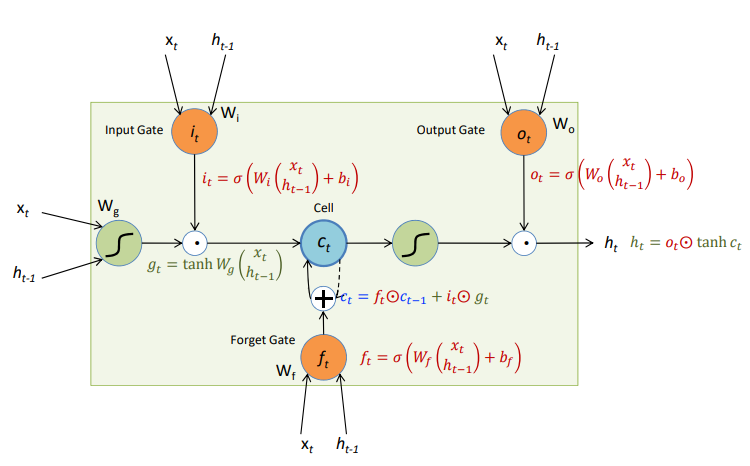

## Differences between RNN and LSTM

**RNN**

Architecture: Simple recurrent connection

Pros: Simple, fast training

Cons: Vanishing gradient problem, poor long-term memory

**LSTM**

Architecture: Input, forget, output gates + cell state

Gates: 3 (Input, Forget, Output)

Pros: Excellent long-term memory, robust to vanishing gradients

Cons: Computationally expensive, more parameters

In [3]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # LSTM params
        # Input gate
        self.W_xi = nn.Linear(input_size, hidden_size)
        self.W_hi = nn.Linear(hidden_size, hidden_size)
        
        # Forget gate
        self.W_xf = nn.Linear(input_size, hidden_size)
        self.W_hf = nn.Linear(hidden_size, hidden_size)
        
        # Output gate
        self.W_xo = nn.Linear(input_size, hidden_size)
        self.W_ho = nn.Linear(hidden_size, hidden_size)
        
        # Cell
        self.W_xc = nn.Linear(input_size, hidden_size)
        self.W_hc = nn.Linear(hidden_size, hidden_size)
        
        # Output layer
        self.W_hy = nn.Linear(hidden_size, output_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x, hidden=None):
        # x shape: (seq_len, batch_size, input_size)
        # hidden: tuple of (h_0, c_0) where h_0: (batch_size, hidden_size), c_0: (batch_size, hidden_size)
        
        if hidden is None:
            h = torch.zeros(x.size(1), self.hidden_size)
            c = torch.zeros(x.size(1), self.hidden_size)
        else:
            h, c = hidden
        
        outputs = []
        for t in range(x.size(0)):  # travers time step
            # Input gate
            i_t = self.sigmoid(self.W_xi(x[t]) + self.W_hi(h))
            # Forget gate
            f_t = self.sigmoid(self.W_xf(x[t]) + self.W_hf(h))
            # Output gate
            o_t = self.sigmoid(self.W_xo(x[t]) + self.W_ho(h))
            # Cell
            c_tilde = self.tanh(self.W_xc(x[t]) + self.W_hc(h))
            
            # Renew cell
            c = f_t * c + i_t * c_tilde
            # Update
            h = o_t * self.tanh(c)
            
            output = self.W_hy(h)
            outputs.append(output)
        
        outputs = torch.stack(outputs)  # (seq_len, batch_size, output_size)
        return outputs, (h, c)

# init set
input_size = 1
hidden_size = 32
output_size = 1
seq_len = 20
batch_size = 16

# create model
model = SimpleLSTM(input_size, hidden_size, output_size)
print(model)

SimpleLSTM(
  (W_xi): Linear(in_features=1, out_features=32, bias=True)
  (W_hi): Linear(in_features=32, out_features=32, bias=True)
  (W_xf): Linear(in_features=1, out_features=32, bias=True)
  (W_hf): Linear(in_features=32, out_features=32, bias=True)
  (W_xo): Linear(in_features=1, out_features=32, bias=True)
  (W_ho): Linear(in_features=32, out_features=32, bias=True)
  (W_xc): Linear(in_features=1, out_features=32, bias=True)
  (W_hc): Linear(in_features=32, out_features=32, bias=True)
  (W_hy): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
)


In [4]:
# use PyTorch's LSTM
class PyTorchLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(PyTorchLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_size, output_size) # there is no output layer in nn.LSTM, extra output layer is needed
        
    def forward(self, x, hidden=None):
        # x shape: (seq_len, batch_size, input_size)
        if hidden is None:
            h_0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
            c_0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
            hidden = (h_0, c_0)
        
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)  # (seq_len, batch_size, output_size)
        return out, hidden

# create PyTorch LSTM model
pytorch_model = PyTorchLSTM(input_size, hidden_size, output_size)
print(pytorch_model)

PyTorchLSTM(
  (lstm): LSTM(1, 32)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [8]:
# train
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        
        # transpose the dims: (batch_size, seq_len, input_size) -> (seq_len, batch_size, input_size)
        X_train_t = X_train.transpose(0, 1)
        y_train_t = y_train.transpose(0, 1)
        
        # forward
        outputs, _ = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss
        model.eval()
        with torch.no_grad():
            X_test_t = X_test.transpose(0, 1)
            y_test_t = y_test.transpose(0, 1)
            test_outputs, _ = model(X_test_t)
            test_loss = criterion(test_outputs, y_test_t)
        
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        
        if epoch % 40 == 0:
            print(f'Epoch [{epoch}/{epochs}], Train Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}')
    
    return train_losses, test_losses

# train
print("开始训练LSTM模型...")
train_losses, test_losses = train_model(pytorch_model, X_train, y_train, X_test, y_test, epochs=200, lr=0.001)

开始训练LSTM模型...
Epoch [0/200], Train Loss: 0.013350, Test Loss: 0.016038
Epoch [40/200], Train Loss: 0.011568, Test Loss: 0.011525
Epoch [80/200], Train Loss: 0.010553, Test Loss: 0.010494
Epoch [120/200], Train Loss: 0.010015, Test Loss: 0.009961
Epoch [160/200], Train Loss: 0.009628, Test Loss: 0.009590


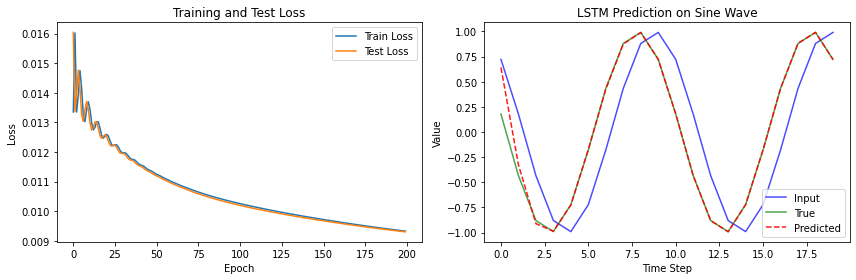

In [9]:
# draw train loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

# draw predict result
plt.subplot(1, 2, 2)
pytorch_model.eval()
with torch.no_grad():
    # choose one sample
    test_sample = X_test[0:1]  # (1, seq_len, 1)
    test_target = y_test[0:1]  # (1, seq_len, 1)
    
    # predict
    test_sample_t = test_sample.transpose(0, 1)  # (seq_len, 1, 1)
    prediction, _ = pytorch_model(test_sample_t)
    prediction = prediction.transpose(0, 1)  # (1, seq_len, 1)
    
    # visualize
    time_steps = range(20)
    plt.plot(time_steps, test_sample[0].numpy(), 'b-', label='Input', alpha=0.7)
    plt.plot(time_steps, test_target[0].numpy(), 'g-', label='True', alpha=0.7)
    plt.plot(time_steps, prediction[0].numpy(), 'r--', label='Predicted', alpha=0.9)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.title('LSTM Prediction on Sine Wave')

plt.tight_layout()
plt.show()

In [ ]:
# A complete example
if __name__ == "__main__":
    # set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    # gen date
    X, y = generate_sine_wave_data(seq_len=20, num_samples=1000)
    X, y = X.to(device), y.to(device)
    
    # split data
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # create model
    input_size = 1
    hidden_size = 32
    output_size = 1
    
    model = PyTorchLSTM(input_size, hidden_size, output_size).to(device)
    
    # train
    train_losses, test_losses = train_model(
        model, X_train, y_train, X_test, y_test, 
        epochs=200, lr=0.001
    )
    
    print("训练完成!")
    
    # loss
    print(f"最终训练损失: {train_losses[-1]:.6f}")
    print(f"最终测试损失: {test_losses[-1]:.6f}")

# Gated Recurrent Unit(GRU)
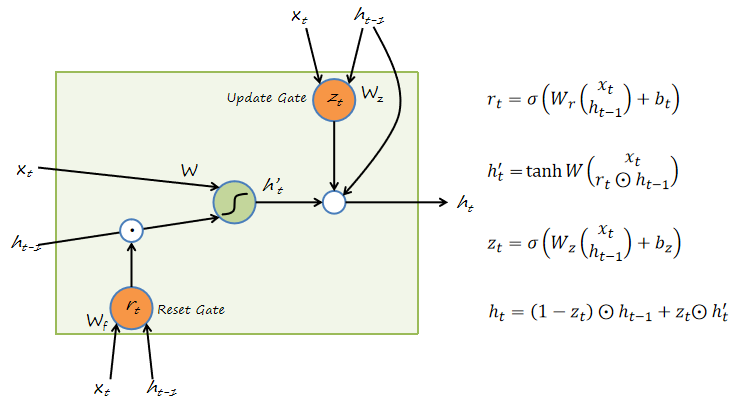

## Feature

Architecture: Update and reset gates

Gates: 2 (Update, Reset)

Pros: Good balance of performance and efficiency

Cons: Slightly less expressive than LSTM for very long sequences


In [10]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleGRU, self).__init__()
        self.hidden_size = hidden_size
        
        # GRU params
        # Update gate
        self.W_xz = nn.Linear(input_size, hidden_size)
        self.W_hz = nn.Linear(hidden_size, hidden_size)
        
        # Reset gate
        self.W_xr = nn.Linear(input_size, hidden_size)
        self.W_hr = nn.Linear(hidden_size, hidden_size)
        
        # Hidden state
        self.W_xh = nn.Linear(input_size, hidden_size)
        self.W_hh = nn.Linear(hidden_size, hidden_size)
        
        # Output layer
        self.W_hy = nn.Linear(hidden_size, output_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x, hidden=None):
        # x shape: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size)
        
        if hidden is None:
            hidden = torch.zeros(x.size(1), self.hidden_size)
        
        outputs = []
        for t in range(x.size(0)):  # travers time step
            # Update gate
            z_t = self.sigmoid(self.W_xz(x[t]) + self.W_hz(hidden))
            # Reset gate
            r_t = self.sigmoid(self.W_xr(x[t]) + self.W_hr(hidden))
            # Hidden state
            h_tilde = self.tanh(self.W_xh(x[t]) + self.W_hh(r_t * hidden))
            # Renew
            hidden = (1 - z_t) * hidden + z_t * h_tilde
            
            output = self.W_hy(hidden)
            outputs.append(output)
        
        outputs = torch.stack(outputs)  # (seq_len, batch_size, output_size)
        return outputs, hidden

# init set
input_size = 1
hidden_size = 32
output_size = 1
seq_len = 20
batch_size = 16

# create model
model = SimpleGRU(input_size, hidden_size, output_size)
print(model)

SimpleGRU(
  (W_xz): Linear(in_features=1, out_features=32, bias=True)
  (W_hz): Linear(in_features=32, out_features=32, bias=True)
  (W_xr): Linear(in_features=1, out_features=32, bias=True)
  (W_hr): Linear(in_features=32, out_features=32, bias=True)
  (W_xh): Linear(in_features=1, out_features=32, bias=True)
  (W_hh): Linear(in_features=32, out_features=32, bias=True)
  (W_hy): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
)


In [11]:
# use PyTorch's GRU
class PyTorchGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(PyTorchGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_size, output_size) # there is no output layer in nn.GRU, extra output layer is needed
        
    def forward(self, x, hidden=None):
        # x shape: (seq_len, batch_size, input_size)
        if hidden is None:
            hidden = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        
        out, hidden = self.gru(x, hidden)
        out = self.fc(out)  # (seq_len, batch_size, output_size)
        return out, hidden

# create PyTorch GRU model
pytorch_model = PyTorchGRU(input_size, hidden_size, output_size)
print(pytorch_model)

PyTorchGRU(
  (gru): GRU(1, 32)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [13]:
# train
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        
        # transpose the dims: (batch_size, seq_len, input_size) -> (seq_len, batch_size, input_size)
        X_train_t = X_train.transpose(0, 1)
        y_train_t = y_train.transpose(0, 1)
        
        # forward
        outputs, _ = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss
        model.eval()
        with torch.no_grad():
            X_test_t = X_test.transpose(0, 1)
            y_test_t = y_test.transpose(0, 1)
            test_outputs, _ = model(X_test_t)
            test_loss = criterion(test_outputs, y_test_t)
        
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        
        if epoch % 40 == 0:
            print(f'Epoch [{epoch}/{epochs}], Train Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}')
    
    return train_losses, test_losses

# train
print("开始训练GRU模型...")
train_losses, test_losses = train_model(pytorch_model, X_train, y_train, X_test, y_test, epochs=200, lr=0.001)

开始训练GRU模型...
Epoch [0/200], Train Loss: 0.033463, Test Loss: 0.033140
Epoch [40/200], Train Loss: 0.020023, Test Loss: 0.019800
Epoch [80/200], Train Loss: 0.013912, Test Loss: 0.013735
Epoch [120/200], Train Loss: 0.011632, Test Loss: 0.011485
Epoch [160/200], Train Loss: 0.010635, Test Loss: 0.010525


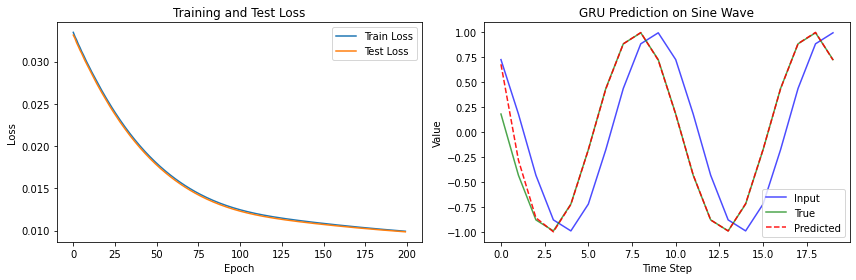

In [14]:
# draw train loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

# draw predict result
plt.subplot(1, 2, 2)
pytorch_model.eval()
with torch.no_grad():
    # choose one sample
    test_sample = X_test[0:1]  # (1, seq_len, 1)
    test_target = y_test[0:1]  # (1, seq_len, 1)
    
    # predict
    test_sample_t = test_sample.transpose(0, 1)  # (seq_len, 1, 1)
    prediction, _ = pytorch_model(test_sample_t)
    prediction = prediction.transpose(0, 1)  # (1, seq_len, 1)
    
    # visualize
    time_steps = range(20)
    plt.plot(time_steps, test_sample[0].numpy(), 'b-', label='Input', alpha=0.7)
    plt.plot(time_steps, test_target[0].numpy(), 'g-', label='True', alpha=0.7)
    plt.plot(time_steps, prediction[0].numpy(), 'r--', label='Predicted', alpha=0.9)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.title('GRU Prediction on Sine Wave')

plt.tight_layout()
plt.show()

In [ ]:
# A complete example
if __name__ == "__main__":
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    # gen date
    X, y = generate_sine_wave_data(seq_len=20, num_samples=1000)
    X, y = X.to(device), y.to(device)
    
    # split data
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # create model
    input_size = 1
    hidden_size = 32
    output_size = 1
    
    model = PyTorchGRU(input_size, hidden_size, output_size).to(device)
    
    # train
    train_losses, test_losses = train_model(
        model, X_train, y_train, X_test, y_test, 
        epochs=200, lr=0.001
    )
    
    print("训练完成!")
    
    # loss
    print(f"最终训练损失: {train_losses[-1]:.6f}")
    print(f"最终测试损失: {test_losses[-1]:.6f}")

## Conclusion

Training Speed: RNN > GRU > LSTM

Memory Capacity: LSTM ≥ GRU > RNN

Parameter Efficiency: RNN > GRU > LSTM

Long-term Dependencies: LSTM > GRU > RNN